In [ ]:
!pip install sentence_transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
warnings.filterwarnings('ignore')

# Step 1 - Load the data

In [5]:
full_df = pd.read_csv("/content/drive/MyDrive/metadata.csv")
dfs = []
for year in range(2019, 2021):
    df = pd.read_csv(f"/content/drive/MyDrive/310Project/deduplicated_dataset_{year}.csv", index_col=0)
    df.drop(columns=["minhash"], inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
# Left join on the "cord_uid" column
df = pd.merge(df, full_df[['cord_uid', 'abstract']], on="cord_uid", how="left")
df.dropna(subset=['abstract'], inplace=True) #drop articles with null abstracts
df.to_pickle("prepared_data.pkl")

In [6]:
df = pd.read_pickle("prepared_data.pkl")

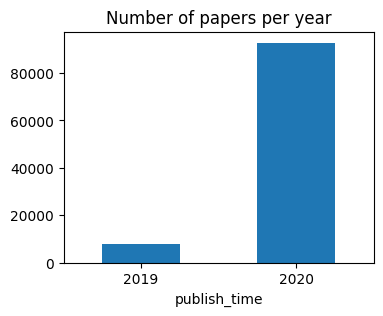

In [7]:
# Plot the number of papers per year
df.groupby("publish_time").count()["cord_uid"].plot(kind="bar",
    title="Number of papers per year", figsize=(4, 3))
plt.xticks(rotation=0)
plt.show()

# Step 1 - Get sentence embeddings

In [8]:
DEVICE = "cuda"
SENTENCE_ENCODER = SentenceTransformer('all-mpnet-base-v2', device=DEVICE)
embeddings = SENTENCE_ENCODER.encode(df.abstract.tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3147 [00:00<?, ?it/s]

In [ ]:
#embeddings = np.load("data/embeddings.npy")

In [21]:
# Concat embeddings to dataframe
df['Embeddings'] = list(embeddings)


In [22]:
df.to_csv('/content/drive/MyDrive/310Project/embeddings.csv')

# Step 2 - Topic Modeling for 2019

In [10]:
year = 2019

df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

Processing year 2019 with 7883 samples...


In [11]:
# Concat embeddings to dataframe
embedding_df = np.stack(df_year.Embeddings.tolist())
print(embedding_df.shape)

(7883, 768)


In [12]:
# Perform PCA
pca = PCA(n_components=0.90)
embedding_pca = pca.fit_transform(embedding_df)
print(f"Reduced {embedding_df.shape[1]} to {embedding_pca.shape[1]} dimensions.")

Reduced 768 to 197 dimensions.


In [13]:
# KMeans
kmeans_data = dict()

for k in tqdm(range(5, 20)):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding_pca)
    kmeans_data[k] = dict(
        labels=kmeans.labels_,
        inertia=kmeans.inertia_,
    )

100%|██████████| 15/15 [01:11<00:00,  4.77s/it]


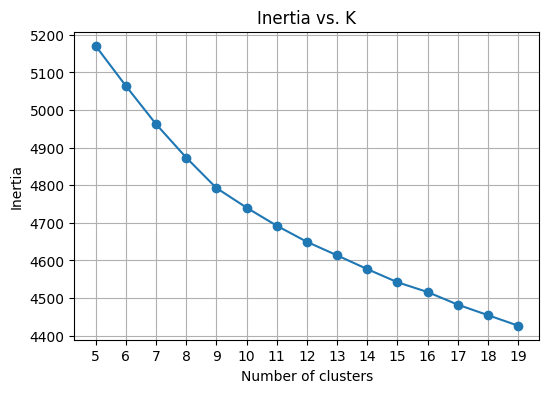

In [14]:
# Plot the inertia vs. K
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(list(kmeans_data.keys()), [km['inertia'] for km in kmeans_data.values()], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. K')
ax.set_xticks(list(kmeans_data.keys()))
ax.grid(True)
plt.show()

In [15]:
# Choose K = 9
k = 9

In [18]:
# Save the labels
topic_idx = kmeans_data[k]['labels']
df_year['topics9_idx'] = topic_idx
df_year.to_pickle('/content/drive/MyDrive/310Project/2019_df_year.pkl')#changed name to 2019_df_year

In [19]:
# Perform T-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_df)

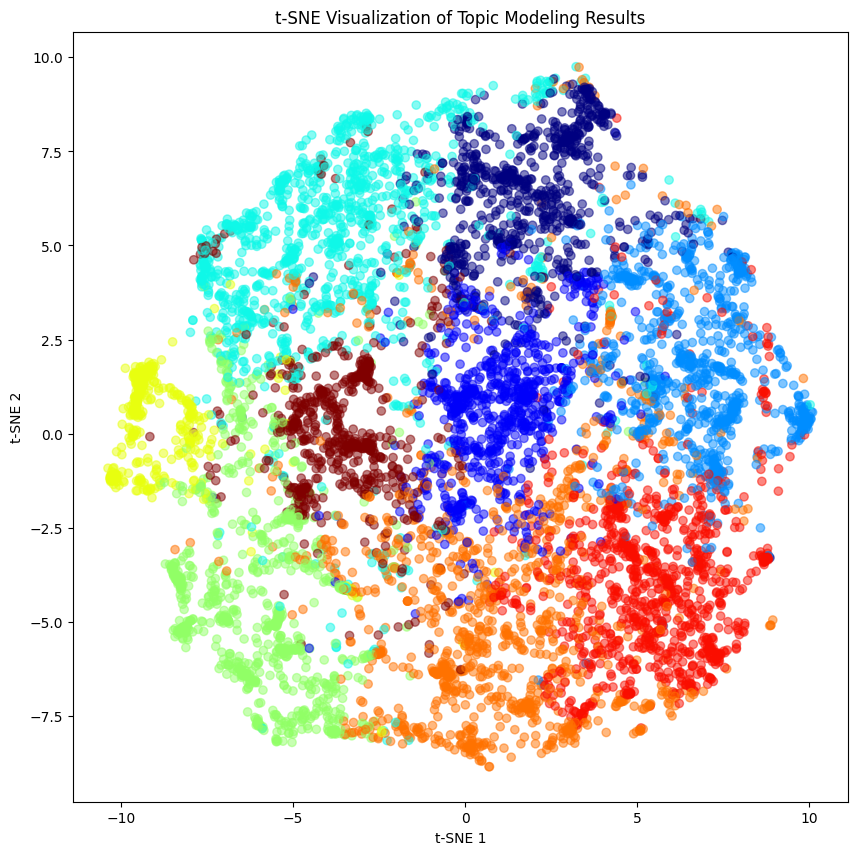

In [20]:
# Plot the T-SNE results
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df_year.topics9_idx,
            cmap=plt.cm.get_cmap("jet", 20), alpha=0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Topic Modeling Results")
plt.show()

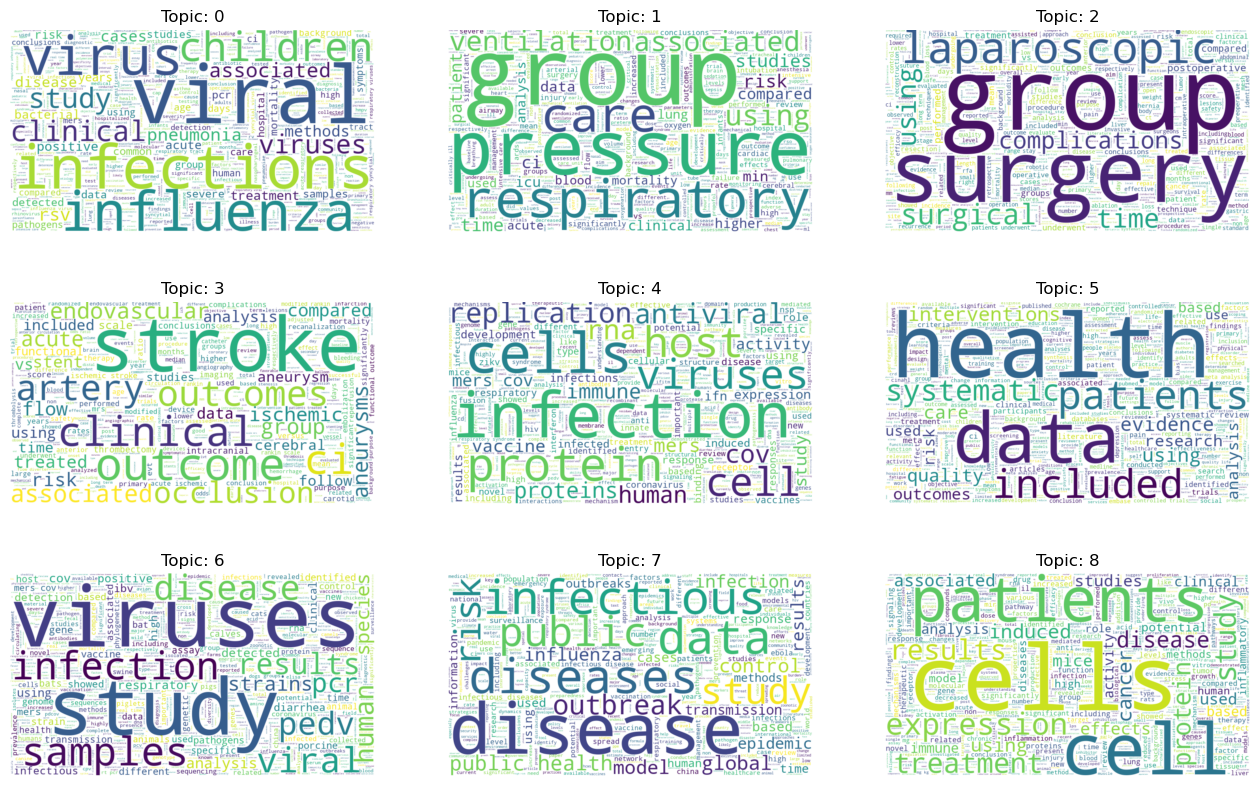

In [ ]:
# Generate word cloud for each topic
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()
pattern = re.compile("[^a-zA-Z]")

keywords = []

for i in range(9):
    df_topic = df_year[df_year.topics9_idx == i]

    corpus = df_topic.abstract.values
    # Remove non-alphabetical characters
    corpus = [re.sub(pattern, " ", text) for text in corpus]

    # Use TF-IDF to extract frequencies since it is more flexible
    # Remove words that appear in more than 50% of the documents
    # Also include bigrams
    vectorizer = CountVectorizer(max_df=0.5, stop_words="english",
                                 lowercase=True, ngram_range=(1, 2), max_features=1000)
    vectorizer.fit(corpus)

    # Get the word frequencies dict(string:float)
    tokens = vectorizer.get_feature_names_out()
    freqs = vectorizer.transform(corpus).sum(axis=0).A1
    freqs = freqs / freqs.max()
    tokens_to_freqs = dict(zip(tokens, freqs))
    # Sort the dict by values
    tokens_to_freqs = dict(sorted(tokens_to_freqs.items(), key=lambda x: x[1], reverse=True))
    # Get the top 10 keywords
    keywords.append(list(tokens_to_freqs.keys())[:10])

    # Word cloud
    wordcloud = WordCloud(width=900, height=500,
                          background_color="white", max_words=1628,
                          relative_scaling=1, normalize_plurals=False).generate_from_frequencies(tokens_to_freqs)
    wordcloud.to_file("output/2019/topic_" + str(i) + ".png")
    ax = axes[i]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Topic: " + str(i))

plt.show()

In [ ]:
# Save the keywords to file
with open("output/2019/keywords.json", 'w') as f:
    json.dump(keywords, f)